# 教程 4: MBHBs & MCMC

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *

第四个教程介绍了MBHB 波形，包括如何生成波形、添加 LISA 响应、计算似然，最后使用 MBHB 运行 MCMC。

## 任务 1： 生成 IMRPhenomHM 波形

首先为 MBHB 生成 IMRPhenomHM 波形。选择合理的参数构建波形，并将其与特征应变表示中的 LISA 灵敏度曲线 (LISASens) 对照绘制。提示：设置 `f_ref = 0.0`。生成波形后，可以访问并更新作为类属性的内容信息。

In [2]:
# imports 
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase
from lisatools.sensitivity import get_sensitivity

No CuPy or GPU PhenomHM module.


In [3]:
wave_gen = PhenomHMAmpPhase()

m1 = 1e6
m2 = 4e5
chi1 = 0.5
chi2 = 0.7
dist = 12 * 1e9 * PC_SI
phi_ref = 0.9
f_ref = 1.2
t_ref = 1e6 # 秒
length = 100

wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)

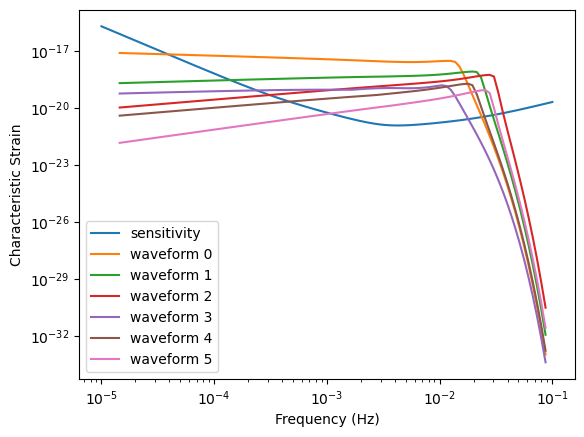

In [4]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens", return_type="char_strain") 


plt.loglog(fn, Sn_char_strain,label='sensitivity')
for i in range(6):
    char_strain = wave_gen.freqs * wave_gen.amp[0, i]
    a='waveform '+str(i)
    plt.loglog(wave_gen.freqs, char_strain, label=a)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")
plt.legend()
plt.show()

## 任务 2：添加响应。

重复上述任务，并添加响应。
在 BBHx 中，响应会通过使用的主波形制作类自动添加： `BBHWaveformFD`。灵敏度应为 `A1TDISens`。

In [5]:
# imports
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.
No CuPy or GPU interpolation available.


In [6]:
tdi_wave_gen = BBHWaveformFD()

In [7]:
m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # 秒
length = 1024

# 设置数据存储区
Tobs = YRSID_SI / 12.  # 一个月
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt
freqs = np.fft.rfftfreq(N, dt)

AET = tdi_wave_gen(m1,m2,chi1,chi2,dist, phi_ref,f_ref, inc,lam,beta,psi,t_ref,length=1024, combine=False,fill=True,squeeze=True,freqs=freqs)

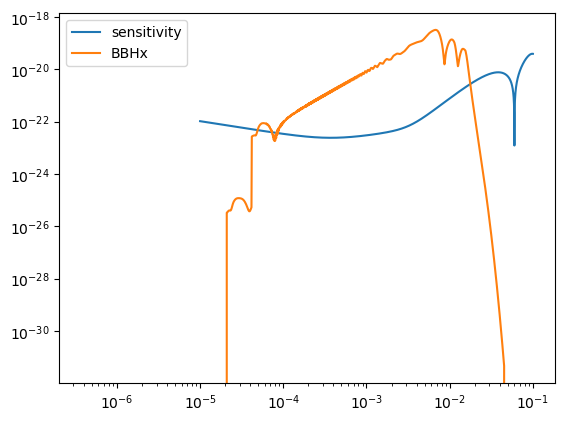

In [8]:
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")
plt.loglog(fn, Sn_char_strain, label="sensitivity")
plt.loglog(freqs, freqs * np.abs(AET[0,0]),label="BBHx")
plt.legend()
plt.show()

## 任务 3：加入一个 MBHB 并计算其信噪比

把前面学习的 Lisatools 知识和 BBHx 的知识结合起来。

使用上述相同方法，设置一个完整的 AnalysisContainer 并加入一个 MBHB 信号。计算其信噪比。

In [9]:
# imports
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [10]:
def wrap(*args, **kwargs):
    return tdi_wave_gen(*args, **kwargs)[0]

In [11]:
data = DataResidualArray(AET[0], f_arr=freqs)
sens_mat = AET1SensitivityMatrix(data.f_arr)
analysis = AnalysisContainer(data, sens_mat, signal_gen=wrap)

/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [12]:
analysis.snr()

3233.4754750915417

用`calculate_signal_likelihood`计算似然。

In [13]:
analysis.calculate_signal_likelihood(
    m1 * 1.0001,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    ),
    source_only=True
)

-7.643172532320023

## 任务 4：MBHBs背景下的MCMC

利用 `Eryn` 教程中的知识运行 MBHBs 背景下的 MCMC。首先运行四个参数：`(mT、q、phi_ref、t_ref)`。可以直接使用 `Eryn` TransformContainer，或者用一个包装过的似然值临时替代固定参数并进行必要的转换。如果使用似然值，需要注意波形发生器用到了 `m1` 和 `m2`，所以需要先在似然函数中对它们进行转化。可以使用 EnsembleSampler 的`periodic` kwarg 运行 `phi_ref`，将其作为一个周期性变量包装在边缘。

这个方法的运行速度不会很快。运行采样器中的少量样本，然后进入下一步。

In [14]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [15]:
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
    )
    return ll

In [16]:
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist, 
    f_ref, 
    inc,
    lam,
    beta,
    psi,
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [17]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [06:53<00:00, 41.30s/it]


## 任务 5：添加外差以提速

完成一次采样运行需要很长时间。一种加快波生成速度的技术叫做外差法。使用参数子集需要对外差似然进行包装，或者可以使用 `Eryn` TransformFunction。

In [18]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

No CuPy


In [19]:
# 使用多少频率
length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# 初始化似然值
like_het = HeterodynedLikelihood(
    tdi_wave_gen,
    freqs,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

array([-0.00275878])

In [20]:
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    # 
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [21]:
ll_comp = wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, analysis)
ll_het = het_wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, like_het)
print(ll_het, ll_comp)

[-0.00275878] -0.0


In [22]:
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [23]:
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:39<00:00,  1.92it/s]


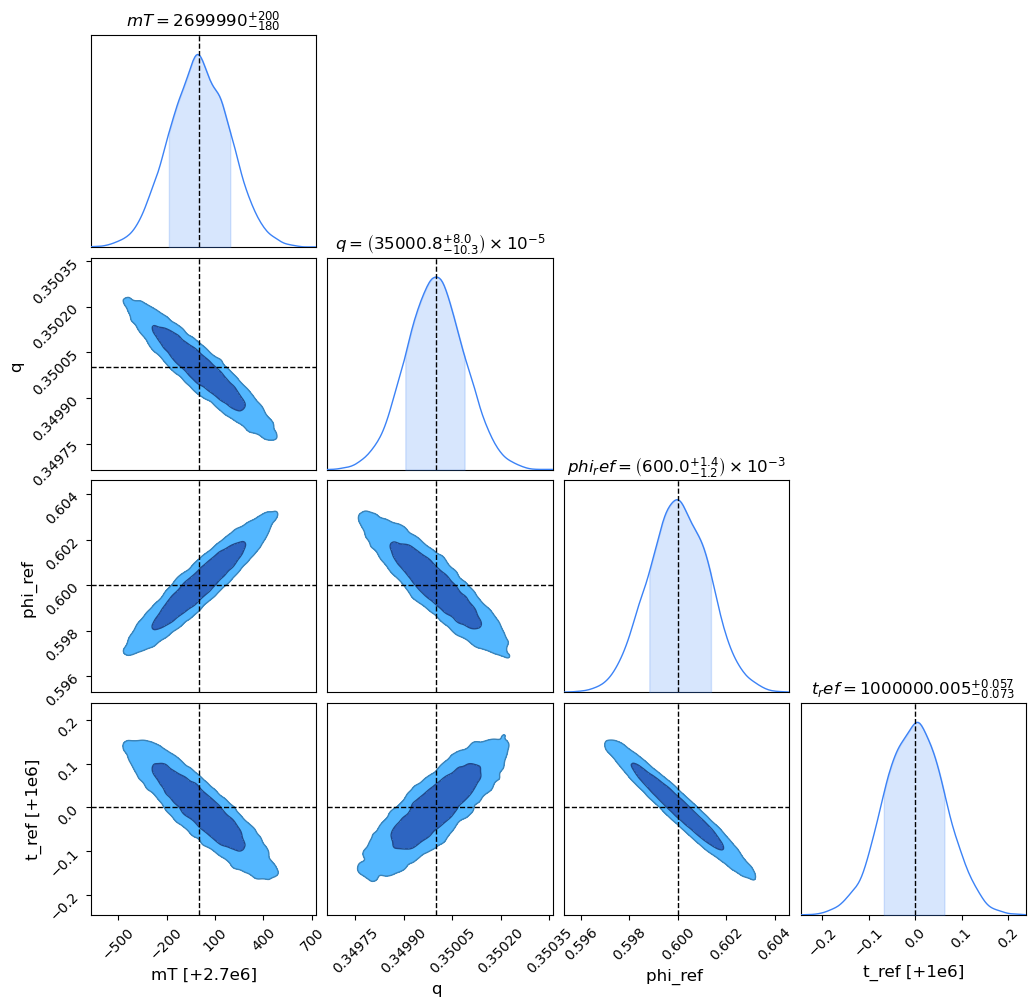

In [24]:
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "phi_ref", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "phi_ref": injection_params_sub[2], "t_ref": injection_params_sub[3]}))
fig = c.plotter.plot()

通过对先验采样，检查外差法与基本似然的匹配程度。每次计算前都需要更新参考模板，因为从先验值中取样可能离真实点较远。可以使用 `HeterodynedLikelihood.init_heterdyne_info` 进行更新。警告：如果运行下一个框的内容，可能会使上面的计算变得复杂，因此要注意运行顺序。

In [25]:
num = 10
for params in priors["mbh"].rvs(num):
    update_params = injection_params.copy()
    mT = params[0]
    q = params[1]
    m1 = mT / (1 + q)
    m2 = mT * q / (1 + q)
    update_params[np.array([0, 1, 5, 11])] = np.array([m1, m2, params[2], params[3]])
    like_het.init_heterodyne_info(
        update_params
    )
    ll_comp = wrapper_likelihood(params, fixed_parameters, freqs, analysis)
    ll_het = het_wrapper_likelihood(params, fixed_parameters, freqs, like_het)
    print(ll_comp, ll_het, np.abs(ll_comp - ll_het), np.abs(ll_comp - ll_het) / np.abs(ll_comp))

-13579707.982156338 [-13579708.68366645] [0.70151011] [5.16587037e-08]
-5936906.879108399 [-5936907.05080217] [0.17169377] [2.89197344e-08]
-5621248.154648112 [-5621247.23620012] [0.91844799] [1.63388622e-07]
-16541338.344461253 [-16541337.15307429] [1.19138696] [7.20248225e-08]
-6776226.922283695 [-6776227.1577747] [0.23549101] [3.47525269e-08]
-6514235.732480545 [-6514234.65769024] [1.0747903] [1.64991006e-07]
-5795933.327490873 [-5795930.92605751] [2.40143336] [4.14330742e-07]
-8981657.232154343 [-8981655.45482687] [1.77732747] [1.97884135e-07]
-13118751.581893913 [-13118749.70800222] [1.87389169] [1.42840702e-07]
-18631041.75822194 [-18631040.22412542] [1.53409652] [8.23408877e-08]


## 学习总结
在教程四中，学习了一种新的波形：IMRPhenomHM波形，这是一种双黑洞系统的螺旋合并和振荡波形模型，并绘制了它的图像和灵敏度，还有BBHWaveformFD中添加响应的方法，我们可以通过响应函数绘制波形，并将它和灵敏度函数绘制在图上进行对照。

在下面的模块，我们实现了把前面的内容和该教程学习的MBHB相结合，去分析波的特征数据，比如信噪比。这里用到了之前学习的AnalysisContainer，这个容器可以之间在内部存储和计算信噪比和似然值，十分方便。通过多次试验我对使用AnalysisContainer的原因有了更深的了解。

接下来我们把之前学习构建的MCMC模型运用到MBHBs的分析中来，这里教了两种方法，用一个wrapper likelihood转换后去求解，这种方法的运行速度较慢；另一种方法是外差法，通过运行数据我们发现这种算法的内容较多，但是运行效率更高。同样要用到转换方法，如TransformFunction。检查外差法和基本似然方法的符合程度，我们发现两者数据差距很好，可见外差法也是一个较为精确的求解MCMC的方法，且运算效率较高，可以在引力波数据分析中推广。